# 1 Load packages and functions

In [8]:
import numpy as np
import pandas as pd
import collections
import os
import matplotlib.pyplot as plt
import datetime, time
import scipy


import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas.core.algorithms as algos
from pandas import Series
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, dot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Reshape, BatchNormalization, TimeDistributed, \
                         Lambda, Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.backend import abs

from tensorflow.keras.layers import Dense, Dropout, Flatten, dot, Permute, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D

from tensorflow.keras.layers import add

In [10]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    epsilon = 1e-10 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(epsilon,np.abs(y_true)))) * 100

In [12]:
def smape(A, F):
    return ((100.0/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))+ np.finfo(float).eps))

In [39]:
# Relative root mean square error
def RRMSE (real, predicted):
  a = np.linalg.norm((real-predicted), ord='fro')
  b = np.linalg.norm(real, ord='fro')
  return(a/b)

# 2 Load dataset

In [15]:
######################################################
### Load dataset
######################################################
#import dill
#filename_save = open('Cilin3D_AML_20.pkl','rb')
#tensor = dill.load(filename_save)
######################################################

### Rodrigo, cargar estructura de datos, tensor

In [18]:
print(tensor.shape)

(20, 499)


### Dataset characteristics

In [19]:
# min, max, range and standard deviation of values
min_val = np.amin(tensor)
max_val = np.amax(tensor)
range_val = np.ptp(tensor)
std_val =np.std(tensor)
print(min_val, max_val)
print(range_val) # value range
print(std_val)

-475.89549944069927 204.5281599800036
680.4236594207028
112.36652408219521


In [20]:
# Quantiles of data
np.quantile(tensor.flatten(), np.arange(0,1,0.1))

array([-475.89549944,  -30.64634805,   -9.979747  ,   -5.96297768,
         -3.31892845,   -0.69624418,    1.8948417 ,    4.53772701,
          7.45385114,   18.12573463])

### Distribution of values

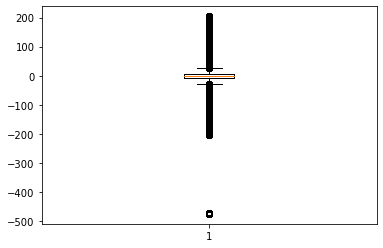

In [22]:
import numpy as np
import matplotlib.pyplot as plt

plt.boxplot(tensor.flatten())
plt.show()

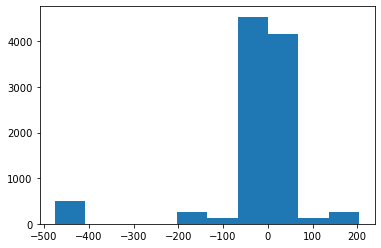

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(tensor.flatten(), density=False)
plt.show()

### Data scaling

In [24]:
tensor_norm = (tensor-min_val)/range_val
scipy.stats.describe(tensor_norm.flatten())

DescribeResult(nobs=9980, minmax=(0.0, 1.0), mean=0.6646146579783964, variance=0.02727461314851619, skewness=-3.1008923912379194, kurtosis=10.227021198311078)

In [22]:
np.quantile(tensor_norm.flatten(), np.arange(0,1,0.1))

array([0.        , 0.65437047, 0.68474361, 0.69064695, 0.69453283,
       0.69838732, 0.70219537, 0.70607954, 0.71036529, 0.72604947])

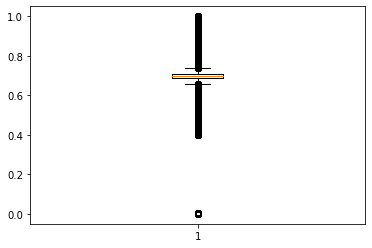

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plt.boxplot(tensor_norm.flatten())
plt.show()

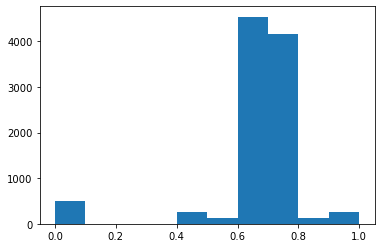

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(tensor_norm.flatten(), density=False)
plt.show()

### Datset configuration

In [26]:
total_length = tensor_norm.shape[1] # number of sbapshots
channels_n = 0                      # number of channels, assuming each snapshot is an image with n channels
dim_x = tensor_norm.shape[0]        # following the simil that each snapshot is an image, the dimension x of that image
dim_y = 0                           # following the simil that each snapshot is an image, the dimension y of that image

print('total_length: ', total_length)
print('channels_n: ', channels_n)
print('dim_x: ', dim_x)
print('dim_y: ', dim_y)

total_length:  499
channels_n:  0
dim_x:  20
dim_y:  0


# 3 Prepare training and test sets

In [27]:
# We will use a data generator
import math
class DataGenerator(tf.keras.utils.Sequence): 
    'Generates data for Keras'
    def __init__(self, data, list_IDs, batch_size=5, dim=(20), 
                 k = 624, p = 1, 
                 shuffle=True, till_end = False, only_test = False):
        'Initialization'
        self.data = data
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.p = p
        self.k = k
        self.till_end = till_end
        self.only_test = only_test
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.till_end:
          lenx = math.ceil((len(self.list_IDs) / self.batch_size))
        else:
          lenx = int(np.floor(len(self.list_IDs) / self.batch_size))
        return lenx

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        if self.only_test:
          return X
        else:
          return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, depth)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.k))
        y = [np.empty((self.batch_size, self.dim))]*self.p

        y_inter = np.empty((self.batch_size, self.dim, p))

        # Generate data
        lenn = len(list_IDs_temp)
        for i, ID in enumerate(list_IDs_temp):
            # Store Xtrain
            X[i,:,:] = self.data[:,ID:ID+k]
            # Store Ytrain
            y_inter[i,:,:] = self.data[:,ID+k:ID+k+p] 

        for j in range(self.p):
          y[j] = y_inter[:,:,j]
          y[j] = np.reshape(y[j], (lenn, -1)) 

        X = X.transpose((0,2,1))

        return X, y
    
    

In [28]:
# Configure the data generators

# Prepare the dataset indexes
period_transitorio = 0
stride_train = 1
stride_val = 1
stride_test = 1
test_prop = 0.40
val_prop = 0.15

batch_size=5
dim=(dim_x)
print("dim: ",dim)
k = 10  # number of snapshots used as predictors
p = 6   # number of snapshots used as time-ahead predictions



test_length = int(test_prop * total_length)
val_length  = int((total_length - test_length) * val_prop)
train_length = total_length - val_length - test_length
    
if int(train_length-period_transitorio-(k+p)) < 0:
    train_n = 0
elif int((train_length-period_transitorio-(k+p))//stride_train) == 0:
    train_n = 1
else: 
    train_n = int(((train_length-period_transitorio)-(k+p))//stride_train)
    
if int(test_length-(k+p)) < 0:
    test_n = 0
elif int((test_length-(k+p))//stride_test) == 0:
    test_n = 1
else: 
    test_n = int((test_length-(k+p))//stride_test)

if int(val_length-(k+p)) < 0:
    val_n = 0
elif int((val_length-(k+p))//stride_val) == 0:
    val_n = 1
else: 
    val_n = int((val_length-(k+p))//stride_val)

# Indices for the beginnings of each batch
train_idxs = np.empty([train_n], dtype='int')
val_idxs = np.empty([val_n], dtype='int')
test_idxs = np.empty([test_n], dtype='int')

j = period_transitorio
for i in range(train_n):
    train_idxs[i] = j
    j = j+stride_train

j = train_length
for i in range(val_n):
    val_idxs[i] = j
    j = j+stride_val

j = train_length + val_length
for i in range(test_n):
    test_idxs[i] = j
    j = j+stride_test



# Generators
training_generator = DataGenerator(tensor_norm, train_idxs,  
                                    dim = dim, 
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = False,
                                    shuffle = True)
validation_generator = DataGenerator(tensor_norm, val_idxs, 
                                    dim = dim, 
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = False,
                                    shuffle = False)
test_generator = DataGenerator(tensor_norm, test_idxs, 
                                    dim = dim, 
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = True,
                                    shuffle = False)

print ('test_length: ', test_length)
print ('val_length: ', val_length)
print ('train_length: ', train_length)
print()
print ('test_n: ', test_n)
print ('val_n: ', val_n)
print ('train_n: ', train_n)
print()
print('test_generator_len: ', len(test_generator))
print('validation_generator_len: ', len(validation_generator))
print('training_generator_len: ', len(training_generator))

dim:  20
test_length:  199
val_length:  45
train_length:  255

test_n:  183
val_n:  29
train_n:  239

test_generator_len:  36
validation_generator_len:  5
training_generator_len:  47


In [30]:
# Prepare Ytest
test_n_adjusted = int(test_n/batch_size)*batch_size  # multiplo de batch_size
Ytest = [np.empty([test_n_adjusted, dim_x], dtype='float64')] * p
Ytest_fl = [np.empty([test_n_adjusted, dim_x ], dtype='float64')] * p

Ytest_inter = np.empty([test_n_adjusted, dim_x, p], dtype='float64')

for i in range(test_n_adjusted):
    j = test_idxs[i]
    Ytest_inter[i,:,:] = tensor_norm[:,j+k:j+k+p]

for r in range(p):    
  Ytest[r] = Ytest_inter[:,:,r]
  Ytest_fl[r] = np.copy(np.reshape(Ytest[r], (test_n_adjusted, -1)) )


# 4 Model LSTM 100 nodes

## 4.1 Prepare model

In [33]:
def create_model(in_shape,  out_dim, p = 3, shared_dim = 1000, act_fun= 'relu'):
    x = Input(shape=in_shape)
    
    v = LSTM(100)(x)
    v = Dense(p*100, activation= act_fun)(v)
    v = Reshape((p,100))(v)

    tt = [1]*p
    
    r = TimeDistributed( Dense(shared_dim, activation=act_fun))(v)
    s = tf.split(r, tt, 1)
    for i in range(p):
      s[i] = Flatten()(s[i])

    o = []
    for i in range(p):
      o.append( Dense(out_dim, activation='sigmoid')(s[i]) )
  
    m = Model(inputs=x, outputs=o)
    m.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return(m)

In [35]:
#create the model

in_shape = [k, dim_x]
out_dim = dim_x 
shared_dim = 80
print(in_shape)
print(out_dim)
print(shared_dim)


model= create_model(in_shape,out_dim,p,shared_dim) 

[10, 20]
20
80


In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 20)]     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100)          48400       input_2[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 600)          60600       lstm_1[0][0]                     
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 6, 100)       0           dense_8[0][0]                    
____________________________________________________________________________________________

In [37]:
# save the best weights 
import sys
save_string = 'colab_Cilin3D_AML_20_LSTM_100 v1'

# save the best weights 
save_best_weights = save_string + '.h5'
save_summary_stats = save_string + '.csv'
save_last_weights = save_string + '_last_w.h5'
save_results_metrics = save_string + '_results_metrics.csv'


## 4.2 Training

In [38]:
np.random.seed(247531338)
#tf.random.set_seed(31722973)

In [78]:
t0 = time.time()
# Model training
callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True, mode='auto'),
             EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
             #,tensorboard
            ]

num_epochs = 70

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks)
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Epoch 1/70
47/47 [==============================] - 3s 70ms/step - loss: 0.0961 - dense_10_loss: 0.0166 - dense_11_loss: 0.0183 - dense_12_loss: 0.0154 - dense_13_loss: 0.0139 - dense_14_loss: 0.0143 - dense_15_loss: 0.0177 - dense_10_mse: 0.0166 - dense_11_mse: 0.0183 - dense_12_mse: 0.0154 - dense_13_mse: 0.0139 - dense_14_mse: 0.0143 - dense_15_mse: 0.0177 - val_loss: 0.0258 - val_dense_10_loss: 0.0044 - val_dense_11_loss: 0.0043 - val_dense_12_loss: 0.0043 - val_dense_13_loss: 0.0041 - val_dense_14_loss: 0.0043 - val_dense_15_loss: 0.0045 - val_dense_10_mse: 0.0044 - val_dense_11_mse: 0.0043 - val_dense_12_mse: 0.0043 - val_dense_13_mse: 0.0041 - val_dense_14_mse: 0.0043 - val_dense_15_mse: 0.0045
Epoch 2/70
47/47 [==============================] - 3s 69ms/step - loss: 0.0290 - dense_10_loss: 0.0048 - dense_11_loss: 0.0049 - dense_12_loss: 0.0048 - dense_13_loss: 0.0048 - dense_14_loss: 0.0048 - dense_15_loss: 0.0049 - dense_10_mse: 0.0048 - dense_11_mse: 0.0049 - dense_12_mse: 0.0

47/47 [==============================] - 4s 83ms/step - loss: 2.2892e-04 - dense_10_loss: 3.5637e-05 - dense_11_loss: 4.1383e-05 - dense_12_loss: 2.7994e-05 - dense_13_loss: 4.0514e-05 - dense_14_loss: 3.5708e-05 - dense_15_loss: 4.7685e-05 - dense_10_mse: 3.5637e-05 - dense_11_mse: 4.1383e-05 - dense_12_mse: 2.7994e-05 - dense_13_mse: 4.0514e-05 - dense_14_mse: 3.5708e-05 - dense_15_mse: 4.7685e-05 - val_loss: 0.0011 - val_dense_10_loss: 1.9083e-04 - val_dense_11_loss: 1.8813e-04 - val_dense_12_loss: 1.7818e-04 - val_dense_13_loss: 1.9229e-04 - val_dense_14_loss: 1.8929e-04 - val_dense_15_loss: 2.0147e-04 - val_dense_10_mse: 1.9083e-04 - val_dense_11_mse: 1.8813e-04 - val_dense_12_mse: 1.7818e-04 - val_dense_13_mse: 1.9229e-04 - val_dense_14_mse: 1.8929e-04 - val_dense_15_mse: 2.0147e-04
Epoch 23/70
47/47 [==============================] - 4s 85ms/step - loss: 2.0049e-04 - dense_10_loss: 3.0793e-05 - dense_11_loss: 3.5954e-05 - dense_12_loss: 2.4599e-05 - dense_13_loss: 3.4712e-05 - d

47/47 [==============================] - 4s 93ms/step - loss: 9.2425e-05 - dense_10_loss: 1.2627e-05 - dense_11_loss: 1.5943e-05 - dense_12_loss: 1.4097e-05 - dense_13_loss: 1.5478e-05 - dense_14_loss: 1.5162e-05 - dense_15_loss: 1.9118e-05 - dense_10_mse: 1.2627e-05 - dense_11_mse: 1.5943e-05 - dense_12_mse: 1.4097e-05 - dense_13_mse: 1.5478e-05 - dense_14_mse: 1.5162e-05 - dense_15_mse: 1.9118e-05 - val_loss: 0.0012 - val_dense_10_loss: 1.9155e-04 - val_dense_11_loss: 1.9055e-04 - val_dense_12_loss: 2.0290e-04 - val_dense_13_loss: 1.8716e-04 - val_dense_14_loss: 1.8649e-04 - val_dense_15_loss: 2.1311e-04 - val_dense_10_mse: 1.9155e-04 - val_dense_11_mse: 1.9055e-04 - val_dense_12_mse: 2.0290e-04 - val_dense_13_mse: 1.8716e-04 - val_dense_14_mse: 1.8649e-04 - val_dense_15_mse: 2.1311e-04
Epoch 43/70
47/47 [==============================] - 4s 90ms/step - loss: 9.2707e-05 - dense_10_loss: 1.3330e-05 - dense_11_loss: 1.5067e-05 - dense_12_loss: 1.4784e-05 - dense_13_loss: 1.5747e-05 - d

In [79]:
# save the last weights 
model.save_weights(save_last_weights)

In [80]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              #'train_acc': history.history['mean_squared_error'],
                              #'valid_acc': history.history['val_mean_squared_error'],
                              'train_loss': history.history['loss'],
                              'valid_loss': history.history['val_loss']})

In [81]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              #'train_acc': history.history['mean_squared_error'],
                              #'valid_acc': history.history['val_mean_squared_error'],
                              'train_loss': history.history['loss'],
                              'valid_loss': history.history['val_loss']})

In [82]:
summary_stats.to_csv(save_summary_stats)    

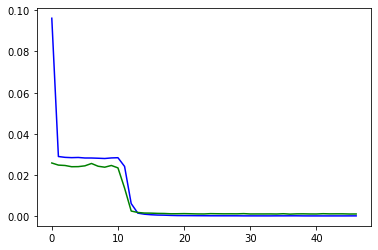

Minimum val_loss at epoch 37 = 0.0010


In [83]:
plt.plot(summary_stats.train_loss, 'b') # blue
plt.plot(summary_stats.valid_loss, 'g') # green
plt.show()

# Find the min validation loss during the training
min_loss, idx = min((loss, idx) for (idx, loss) in enumerate(history.history['val_loss']))
print('Minimum val_loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_loss))
min_loss = round(min_loss, 4)


## 4.3 Inference

In [40]:
t0 = time.time()

model.load_weights(save_best_weights)
Ytest_hat_fl = model.predict(test_generator, verbose=1) 
    
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

36/36 [==============================] - 1s 33ms/step
Minutes elapsed: 0.028612


In [41]:
print('Performance measures on Test data, per sec')
lag = 0
num_sec = Ytest_hat_fl[0].shape[0]
results_table = pd.DataFrame(index=['MSE','MAE','MAD','R2','SMAPE','RRMSE'],columns=range(num_sec))
for i in range(num_sec):
    results_table.iloc[0,i] = mean_squared_error( Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[1,i] = mean_absolute_error(   Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[2,i] = median_absolute_error(  Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[3,i] = r2_score(  Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[4,i] = smape(  Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[5,i] = RRMSE( np.reshape(Ytest_fl[lag][i,:],(-1,1)), np.reshape(Ytest_hat_fl[lag][i,:],(-1,1)))
results_table

Performance measures on Test data, per sec


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
MSE,0.000188959,0.000145489,0.000136522,0.000177163,0.000147723,0.000198973,0.000183766,0.000127874,0.000180044,0.000128544,0.000167801,0.000178429,0.000149144,0.000156012,0.000148116,0.000155567,0.000183384,0.000167595,0.000185087,0.000195604,0.000156619,0.000128947,0.000180414,0.000134818,0.000189866,0.000182351,0.000138158,0.000173297,0.0001365,0.000165288,0.000175794,0.000156614,0.00016193,0.000159545,0.000157275,0.0001773,0.000167859,0.00017942,0.000200215,0.000168091,0.000125801,0.000180004,0.000128077,0.000180318,0.000181704,0.00013969,0.000167123,0.000138339,0.000159826,0.000174498,...,0.000121823,0.00018375,0.000126157,0.000175504,0.000181591,0.000140864,0.000163537,0.000136344,0.000159662,0.000174562,0.00016074,0.000171491,0.000182106,0.000150159,0.000148266,0.000172724,0.000164363,0.000203792,0.000182864,0.00011928,0.000183135,0.000124625,0.00017005,0.000181047,0.000143849,0.000160749,0.000138824,0.000158617,0.000176481,0.000163702,0.000177095,0.000190248,0.000146473,0.000135778,0.000177849,0.000146566,0.00019834,0.00018346,0.000129403,0.000179531,0.000129684,0.000168004,0.000178306,0.000150093,0.000156795,0.000149148,0.000155813,0.000185069,0.00016788,0.000186298
MAE,0.00976236,0.00954155,0.00821809,0.00938158,0.00885497,0.0101989,0.0104668,0.00808104,0.0102543,0.00786822,0.00863191,0.0107572,0.00914896,0.0100378,0.00893229,0.00851488,0.00964407,0.0096589,0.0105352,0.00969549,0.00982735,0.00762623,0.0098568,0.00865398,0.010025,0.0102806,0.00841855,0.0099018,0.00818486,0.00825894,0.0104949,0.00956011,0.00984274,0.00924084,0.00903869,0.00945797,0.00934368,0.0102156,0.0103146,0.00994428,0.00759084,0.00989644,0.00818174,0.00966975,0.0103279,0.0083486,0.0100188,0.00805257,0.00836926,0.0104092,...,0.00754906,0.00990256,0.00792843,0.00945911,0.0105856,0.00847222,0.0101619,0.00784691,0.0084963,0.0101918,0.00981615,0.00981918,0.00966039,0.00958842,0.00864945,0.00945074,0.00939547,0.0103173,0.0104727,0.0075154,0.0103213,0.00775233,0.00917188,0.0109106,0.00891375,0.0103679,0.00813915,0.00864354,0.0100291,0.00958992,0.0101981,0.00978123,0.00957797,0.00818497,0.0094219,0.00887272,0.010181,0.0104756,0.00816188,0.0102267,0.00794004,0.00861443,0.0107245,0.00918448,0.0100222,0.00897817,0.00854884,0.00964278,0.00963748,0.0105693
MAD,0.00518585,0.00734677,0.00466578,0.00401892,0.00612458,0.00672153,0.00749356,0.00450143,0.00657039,0.00499182,0.00469375,0.00908699,0.00619092,0.00834137,0.00484238,0.00448758,0.00603603,0.00597195,0.00953494,0.0046464,0.00788554,0.0033174,0.00497491,0.00617672,0.005837,0.0059016,0.0043154,0.00683183,0.00523625,0.00420754,0.00769467,0.00709438,0.00641495,0.00614061,0.00525497,0.00586676,0.00562953,0.00926656,0.00464662,0.0078096,0.00409592,0.00476213,0.00529722,0.00687644,0.00580737,0.00450232,0.00737009,0.00479604,0.00454249,0.0069909,...,0.00472161,0.00584945,0.00406969,0.00637454,0.00619873,0.00515529,0.00807615,0.00455939,0.00584505,0.00724283,0.00649606,0.0046035,0.00440949,0.00834092,0.00630094,0.00433629,0.00617315,0.00588612,0.0078273,0.00402019,0.00570456,0.00395103,0.00518609,0.00796291,0.0048758,0.00699947,0.00493615,0.00430193,0.00630573,0.00716916,0.00631107,0.00516435,0.00715255,0.00445444,0.00409802,0.00597617,0.00683162,0.0074701,0.00448897,0.00661303,0.005147,0.0044347,0.00917621,0.00643188,0.00821504,0.00492399,0.00448629,0.00597521,0.00578671,0.00984333
R2,0.993211,0.994661,0.994656,0.993004,0.994532,0.992834,0.993173,0.994927,0.992969,0.995363,0.993934,0.993259,0.994074,0.993955,0.994685,0.994335,0.992931,0.993356,0.992954,0.992968,0.994238,0.994932,0.992891,0.995049,0.993157,0.993203,0.994512,0.993248,0.995088,0.994017,0.993329,0.99378,0.993738,

In [42]:
print('Performance measures on Test data, for all time, per time-ahead lag')

results_table_global = pd.DataFrame(index=['MSE','MAE','MAD','R2','SMAPE','RRMSE'],columns=range(p))
for i in range(p):
    results_table_global.iloc[0,i] = mean_squared_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[1,i] = mean_absolute_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[2,i] = median_absolute_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[3,i] = r2_score(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[4,i] = smape(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[5,i] = RRMSE( np.reshape(Ytest_fl[i].flatten(),(-1,1)), np.reshape(Ytest_hat_fl[i].flatten(),(-1,1)))

results_table_global['mean'] = results_table_global.mean(axis=1)
results_table_global

Performance measures on Test data, for all time, per time-ahead lag


,0,1,2,3,4,5,mean
MSE,0.000163411,0.000166252,0.000154061,0.000161721,0.000160573,0.000163027,0.000162
MAE,0.00938503,0.00948159,0.00920709,0.00943223,0.009281,0.00948576,0.009379
MAD,0.00574071,0.00603978,0.00597593,0.00624541,0.00614962,0.00619386,0.006058
R2,0.99389,0.993783,0.994239,0.993953,0.993996,0.993904,0.993961
SMAPE,5.89407,6.20018,4.8466,4.95473,6.05862,6.6397,5.765649
RRMSE,0.0186937,0.0188555,0.0181512,0.0185972,0.018531,0.0186715,0.018583


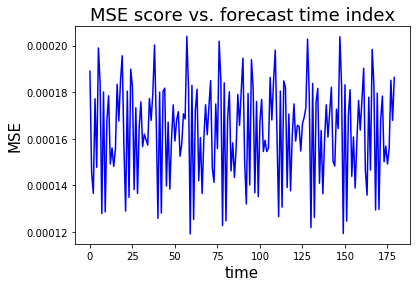

In [43]:
plt.plot(range(num_sec),results_table.iloc[0,:], 'b') # green
plt.title("MSE score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("MSE",fontsize=15);
plt.show()

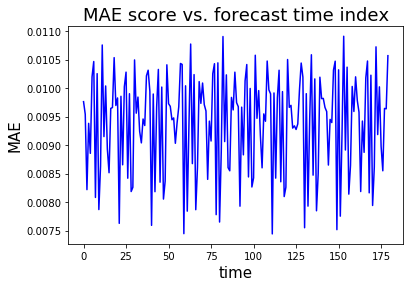

In [44]:
plt.plot(range(num_sec),results_table.iloc[1,:], 'b') # green
plt.title("MAE score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("MAE",fontsize=15);
plt.show()

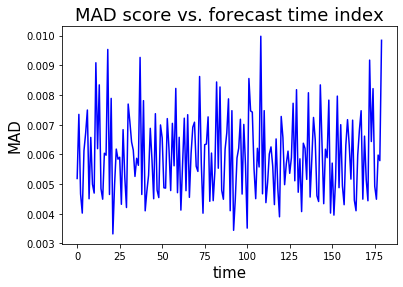

In [45]:
plt.plot(range(num_sec),results_table.iloc[2,:], 'b') # green
plt.title("MAD score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("MAD",fontsize=15);
plt.show()

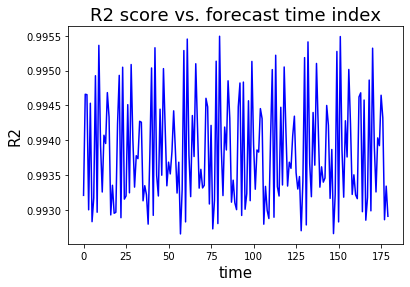

In [46]:
plt.plot(range(num_sec),results_table.iloc[3,:], 'b') # green
plt.title("R2 score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("R2",fontsize=15);
plt.show()

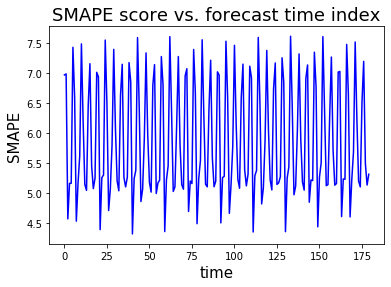

In [47]:
plt.plot(range(num_sec),results_table.iloc[4,:], 'b') # green
plt.title("SMAPE score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("SMAPE",fontsize=15);
plt.show()

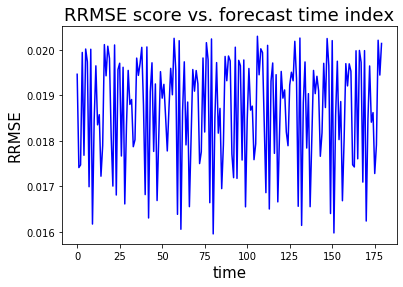

In [48]:
plt.plot(range(num_sec),results_table.iloc[5,:], 'b') # green
plt.title("RRMSE score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("RRMSE",fontsize=15);
plt.show()

## 4.4 Output values

In [50]:
Ytest_hat_fl = model.predict(test_generator, verbose=1) 

# Create the multidimensional arrays for the results and ground-truth values
mat_pred = np.zeros((Ytest_fl[0].shape[0],p,Ytest_fl[0].shape[1]))
mat_ground_truth = np.zeros((Ytest_fl[0].shape[0],p,Ytest_fl[0].shape[1]))
mat_time_slice_index = np.zeros((Ytest_fl[0].shape[0],p),dtype=int)
print(mat_pred.shape)
print(mat_ground_truth.shape)
print(mat_time_slice_index.shape)

# Fill the output arrays
for i in range(p):
    for j in range(Ytest_fl[0].shape[0]):
        mat_pred[j,i,:]=Ytest_hat_fl[i][j,:]
        
for i in range(p):
    for j in range(Ytest_fl[0].shape[0]):
        mat_ground_truth[j,i,:]=tensor.T[test_idxs[j]+k+i,:]

for i in range(p):
    for j in range(Ytest_fl[0].shape[0]):
        mat_time_slice_index[j,i]=test_idxs[j]+k+i     
  
# Predicitions not scaled
mat_pred = mat_pred * range_val + min_val


36/36 [==============================] - 0s 2ms/step
(180, 6, 20)
(180, 6, 20)
(180, 6)


In [58]:
pd.DataFrame(mat_ground_truth[:,:,0])

,0,1,2,3,4,5
0,-471.496986,-472.534036,-471.848552,-472.749320,-471.892269,-471.788204
1,-472.534036,-471.848552,-472.749320,-471.892269,-471.788204,-472.447265
2,-471.848552,-472.749320,-471.892269,-471.788204,-472.447265,-471.924983
3,-472.749320,-471.892269,-471.788204,-472.447265,-471.924983,-472.846218
4,-471.892269,-471.788204,-472.447265,-471.924983,-472.846218,-471.519833
...,...,...,...,...,...,...
175,-471.358914,-472.402244,-471.879936,-472.478993,-472.197641,-471.500800
176,-472.402244,-471.879936,-472.478993,-472.197641,-471.500800,-472.481238
177,-471.879936,-472.478993,-472.197641,-471.500800,-472.481238,-471.795742
178,-472.478993,-472.197641,-471.500800,-472.481238,-471.795742,-472.746209


In [59]:
pd.DataFrame(mat_pred[:,:,0])

,0,1,2,3,4,5
0,-474.675826,-474.927661,-473.912555,-474.627341,-475.022137,-475.640967
1,-474.962621,-473.599337,-472.880901,-473.947453,-475.593821,-474.223825
2,-473.857803,-474.153926,-474.773932,-474.003746,-475.162138,-472.806480
3,-474.453273,-474.952847,-474.622413,-474.073847,-472.472863,-474.820856
4,-474.159340,-474.956923,-473.877615,-474.023111,-473.257285,-475.595727
...,...,...,...,...,...,...
175,-474.494539,-474.839978,-473.943966,-474.560423,-474.366482,-475.663801
176,-475.025605,-474.123651,-472.930785,-474.029377,-475.614302,-474.793156
177,-474.192657,-474.018326,-474.511917,-473.736378,-475.351395,-472.918172
178,-474.319072,-474.785288,-474.770221,-474.291757,-472.716242,-474.492430


### Codigo a meter por Rodrigo

# 5 Model CNN 1D

## 5.1 Prepare model

In [64]:
def create_model_cnn(in_shape,  out_dim, p = 3, shared_dim = 1000, act_fun= 'relu'):
    x = Input(shape=in_shape)
    
    v = Convolution1D(30,3)(x)
    v = Convolution1D(60,3)(v)
    #v = Dense(p*100, activation= act_fun)(v) # it shares weights https://stackoverflow.com/questions/52089601/keras-dense-layers-input-is-not-flattened
    v = Dense(100, activation= act_fun)(v)
    #v = Reshape((p,100))(v)

    tt = [1]*p
    
    r = TimeDistributed( Dense(shared_dim, activation=act_fun))(v)
    s = tf.split(r, tt, 1)
    for i in range(p):
      s[i] = Flatten()(s[i])

    o = []
    for i in range(p):
      o.append( Dense(out_dim, activation='sigmoid')(s[i]) )
  
    m = Model(inputs=x, outputs=o)
    m.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return(m)

In [65]:
#Create the model

in_shape = [k, dim_x]
out_dim = dim_x 
shared_dim = 100
print(in_shape)
print(out_dim)
print(shared_dim)


model= create_model_cnn(in_shape,out_dim,p,shared_dim) 

[10, 20]
20
100


In [66]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10, 20)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 8, 30)        1830        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 60)        5460        conv1d_2[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 6, 100)       6100        conv1d_3[0][0]                   
____________________________________________________________________________________________

In [67]:
# save the best weights 
import sys
save_string = 'colab_Cilin3D_AML_20_CNN1D_1 v1'

# save the best weights 
save_best_weights = save_string + '.h5'
save_summary_stats = save_string + '.csv'
save_last_weights = save_string + '_last_w.h5'
save_results_metrics = save_string + '_results_metrics.csv'


## 5.2 Training 

In [112]:
t0 = time.time()
# Train the model
callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True, mode='auto'),
             EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
             #,tensorboard
            ]
num_epochs = 70

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks)
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Epoch 1/70
47/47 [==============================] - 3s 56ms/step - loss: 0.1031 - dense_18_loss: 0.0154 - dense_19_loss: 0.0168 - dense_20_loss: 0.0190 - dense_21_loss: 0.0202 - dense_22_loss: 0.0150 - dense_23_loss: 0.0167 - dense_18_mse: 0.0154 - dense_19_mse: 0.0168 - dense_20_mse: 0.0190 - dense_21_mse: 0.0202 - dense_22_mse: 0.0150 - dense_23_mse: 0.0167 - val_loss: 0.0260 - val_dense_18_loss: 0.0042 - val_dense_19_loss: 0.0047 - val_dense_20_loss: 0.0040 - val_dense_21_loss: 0.0045 - val_dense_22_loss: 0.0042 - val_dense_23_loss: 0.0044 - val_dense_18_mse: 0.0042 - val_dense_19_mse: 0.0047 - val_dense_20_mse: 0.0040 - val_dense_21_mse: 0.0045 - val_dense_22_mse: 0.0042 - val_dense_23_mse: 0.0044
Epoch 2/70
47/47 [==============================] - 2s 53ms/step - loss: 0.0264 - dense_18_loss: 0.0043 - dense_19_loss: 0.0046 - dense_20_loss: 0.0043 - dense_21_loss: 0.0045 - dense_22_loss: 0.0042 - dense_23_loss: 0.0045 - dense_18_mse: 0.0043 - dense_19_mse: 0.0046 - dense_20_mse: 0.0

47/47 [==============================] - 3s 60ms/step - loss: 4.8672e-04 - dense_18_loss: 7.5856e-05 - dense_19_loss: 8.9689e-05 - dense_20_loss: 7.3644e-05 - dense_21_loss: 9.3674e-05 - dense_22_loss: 7.1817e-05 - dense_23_loss: 8.2037e-05 - dense_18_mse: 7.5856e-05 - dense_19_mse: 8.9689e-05 - dense_20_mse: 7.3644e-05 - dense_21_mse: 9.3674e-05 - dense_22_mse: 7.1817e-05 - dense_23_mse: 8.2037e-05 - val_loss: 0.0012 - val_dense_18_loss: 2.0240e-04 - val_dense_19_loss: 2.0853e-04 - val_dense_20_loss: 2.0543e-04 - val_dense_21_loss: 1.9892e-04 - val_dense_22_loss: 1.8470e-04 - val_dense_23_loss: 1.8464e-04 - val_dense_18_mse: 2.0240e-04 - val_dense_19_mse: 2.0853e-04 - val_dense_20_mse: 2.0543e-04 - val_dense_21_mse: 1.9892e-04 - val_dense_22_mse: 1.8470e-04 - val_dense_23_mse: 1.8464e-04
Epoch 22/70
47/47 [==============================] - 3s 60ms/step - loss: 4.6287e-04 - dense_18_loss: 7.3185e-05 - dense_19_loss: 8.5300e-05 - dense_20_loss: 7.1312e-05 - dense_21_loss: 8.8826e-05 - d

47/47 [==============================] - 3s 63ms/step - loss: 2.2572e-04 - dense_18_loss: 3.6114e-05 - dense_19_loss: 3.9337e-05 - dense_20_loss: 3.3234e-05 - dense_21_loss: 3.8414e-05 - dense_22_loss: 3.7153e-05 - dense_23_loss: 4.1473e-05 - dense_18_mse: 3.6114e-05 - dense_19_mse: 3.9337e-05 - dense_20_mse: 3.3234e-05 - dense_21_mse: 3.8414e-05 - dense_22_mse: 3.7153e-05 - dense_23_mse: 4.1473e-05 - val_loss: 0.0011 - val_dense_18_loss: 1.7613e-04 - val_dense_19_loss: 1.9152e-04 - val_dense_20_loss: 1.7051e-04 - val_dense_21_loss: 1.6779e-04 - val_dense_22_loss: 1.6999e-04 - val_dense_23_loss: 1.9875e-04 - val_dense_18_mse: 1.7613e-04 - val_dense_19_mse: 1.9152e-04 - val_dense_20_mse: 1.7051e-04 - val_dense_21_mse: 1.6779e-04 - val_dense_22_mse: 1.6999e-04 - val_dense_23_mse: 1.9875e-04
Epoch 42/70
47/47 [==============================] - 3s 65ms/step - loss: 2.0522e-04 - dense_18_loss: 3.3340e-05 - dense_19_loss: 3.4388e-05 - dense_20_loss: 3.1559e-05 - dense_21_loss: 3.5044e-05 - d

In [113]:
# save the last weights 
model.save_weights(save_last_weights)

In [114]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              #'train_acc': history.history['mean_squared_error'],
                              #'valid_acc': history.history['val_mean_squared_error'],
                              'train_loss': history.history['loss'],
                              'valid_loss': history.history['val_loss']})

In [115]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              #'train_acc': history.history['mean_squared_error'],
                              #'valid_acc': history.history['val_mean_squared_error'],
                              'train_loss': history.history['loss'],
                              'valid_loss': history.history['val_loss']})

In [116]:
summary_stats.to_csv(save_summary_stats)    

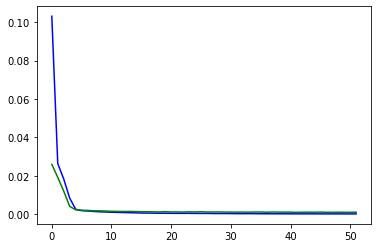

Minimum val_loss at epoch 42 = 0.0010


In [117]:
plt.plot(summary_stats.train_loss, 'b') # blue
plt.plot(summary_stats.valid_loss, 'g') # green
plt.show()

# Find the min validation loss during the training
min_loss, idx = min((loss, idx) for (idx, loss) in enumerate(history.history['val_loss']))
print('Minimum val_loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_loss))
min_loss = round(min_loss, 4)


## 5.3 Inference

In [68]:
t0 = time.time()

model.load_weights(save_best_weights)
#Ytest_hat_fl = model.predict(test_generator, max_queue_size=10, workers=6, use_multiprocessing=True, verbose=1)  
Ytest_hat_fl = model.predict(test_generator, verbose=1) 
    
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

36/36 [==============================] - 0s 10ms/step
Minutes elapsed: 0.006948


In [69]:
print('Performance measures on Test data, per sec')
lag = 0
num_sec = Ytest_hat_fl[0].shape[0]
results_table = pd.DataFrame(index=['MSE','MAE','MAD','R2','SMAPE','RRMSE'],columns=range(num_sec))
for i in range(num_sec):
    results_table.iloc[0,i] = mean_squared_error( Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[1,i] = mean_absolute_error(   Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[2,i] = median_absolute_error(  Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[3,i] = r2_score(  Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[4,i] = smape(  Ytest_fl[lag][i,:], Ytest_hat_fl[lag][i,:])
    results_table.iloc[5,i] = RRMSE( np.reshape(Ytest_fl[lag][i,:],(-1,1)), np.reshape(Ytest_hat_fl[lag][i,:],(-1,1)))
results_table

Performance measures on Test data, per sec


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
MSE,0.000140128,0.000164667,0.000195106,0.000179067,0.000165188,0.000172479,0.000182627,0.000186797,0.000151437,0.000156333,0.000169533,0.000194842,0.000185784,0.000132649,0.000152035,0.000151283,0.00020031,0.000187626,0.000153588,0.000139431,0.000168489,0.000195151,0.000175524,0.000180752,0.000186824,0.000185992,0.00019178,0.00013941,0.000151454,0.000157677,0.000197802,0.000185889,0.000157604,0.000151945,0.000151783,0.000195516,0.000186087,0.000152588,0.000146181,0.000174288,0.000197788,0.000171505,0.000166749,0.000184967,0.000191572,0.000208134,0.000130183,0.000147809,0.000152865,0.000214733,...,0.000198333,0.000169171,0.00016238,0.000179843,0.000193826,0.000197332,0.0001254,0.00014642,0.000152065,0.000219756,0.000187565,0.000156233,0.000144128,0.000154053,0.000194893,0.00018222,0.000157772,0.000157867,0.000181377,0.000189044,0.00016398,0.00016112,0.000171314,0.000195271,0.00018657,0.000123399,0.000146346,0.00015147,0.000210342,0.000188217,0.000155449,0.000140091,0.000167251,0.000195063,0.000179022,0.000166535,0.000174306,0.000183217,0.000187012,0.000150462,0.000155973,0.00016865,0.000195052,0.000186045,0.000134638,0.000152889,0.000151728,0.000199897,0.000187713,0.000153691
MAE,0.0089809,0.00928648,0.0101163,0.0105421,0.0100652,0.0105975,0.0111428,0.0102385,0.00919895,0.00969179,0.0106896,0.0113396,0.0108693,0.00907321,0.0102402,0.00926381,0.0109895,0.0106763,0.0105432,0.00905104,0.009495,0.00991245,0.0100604,0.0103133,0.0109083,0.0114494,0.0105985,0.00853472,0.00986924,0.0101774,0.010972,0.0105244,0.0102535,0.0101433,0.00914389,0.010709,0.0111656,0.0104936,0.00922925,0.0100723,0.010189,0.00989339,0.0100348,0.010708,0.0118206,0.0114718,0.00864821,0.0102599,0.00947207,0.0111345,...,0.0102796,0.00992828,0.00978958,0.0107473,0.0118092,0.0111008,0.00859164,0.0103026,0.00920139,0.0113369,0.0103508,0.0107952,0.00940269,0.00880372,0.0102144,0.0109732,0.0100965,0.0102378,0.0110116,0.0103342,0.00981589,0.00953274,0.0107861,0.0116799,0.0108965,0.00861098,0.0102908,0.00911689,0.0112734,0.0104795,0.0108221,0.00897897,0.00936878,0.010108,0.0105154,0.0100839,0.0106262,0.0111599,0.0102578,0.00913709,0.00969719,0.0106409,0.0113281,0.0108552,0.00918728,0.0102357,0.00929222,0.010974,0.0107494,0.0105474
MAD,0.00702738,0.0071315,0.00730091,0.00911663,0.00746193,0.00882647,0.0107832,0.00931847,0.0051562,0.00609127,0.00977958,0.0106466,0.00925389,0.00666877,0.00994076,0.00677471,0.00856664,0.00862282,0.0101677,0.00593896,0.00784002,0.00565848,0.00729488,0.0089291,0.00702371,0.0111332,0.0100519,0.00511461,0.00751347,0.00720732,0.00765387,0.00771029,0.0100261,0.00889039,0.00631059,0.00802154,0.00978449,0.0100428,0.00771912,0.00782163,0.00625204,0.00786527,0.00737299,0.00806469,0.00997812,0.00972887,0.00543616,0.0084436,0.00647206,0.00943045,...,0.00717125,0.00686097,0.00735163,0.00847521,0.01015,0.0106831,0.00655186,0.00867995,0.0060124,0.0115053,0.00564886,0.0101463,0.00703747,0.00527094,0.00748807,0.00975614,0.00834929,0.00835926,0.00914419,0.0093403,0.00711217,0.00741802,0.0113103,0.0125133,0.00937602,0.00693109,0.0104594,0.00592595,0.00909268,0.00636431,0.0108724,0.00690874,0.00732402,0.00720003,0.00893083,0.00783144,0.00861213,0.010637,0.00915753,0.00505217,0.00609546,0.0101111,0.0102497,0.00928598,0.00695598,0.00989472,0.00670915,0.00872166,0.00892826,0.00992738
R2,0.994966,0.993957,0.992362,0.992929,0.993886,0.993788,0.993216,0.992589,0.994086,0.99436,0.993872,0.992639,0.992618,0.99486,0.994544,0.994491,0.992278,0.992561,0.994153,0.994988,0.993802,0.99233,0.993083,0.993362,0.993267,0.993067,0.992382,0.994568,0.994549,0.994292,0.992494,0.992617,0.993905,0.994547,0.994461,0.992428,0.992627,0.994235,0.9947

In [70]:
print('Performance measures on Test data, for all time, per time-ahead lag')

results_table_global = pd.DataFrame(index=['MSE','MAE','MAD','R2','SMAPE','RRMSE'],columns=range(p))
for i in range(p):
    results_table_global.iloc[0,i] = mean_squared_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[1,i] = mean_absolute_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[2,i] = median_absolute_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[3,i] = r2_score(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[4,i] = smape(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[5,i] = RRMSE( np.reshape(Ytest_fl[i].flatten(),(-1,1)), np.reshape(Ytest_hat_fl[i].flatten(),(-1,1)))

results_table_global['mean'] = results_table_global.mean(axis=1)
results_table_global

Performance measures on Test data, for all time, per time-ahead lag


,0,1,2,3,4,5,mean
MSE,0.000170504,0.000162572,0.000169028,0.000153749,0.000163088,0.000160648,0.000163
MAE,0.0102248,0.0100696,0.00997361,0.0096694,0.00998881,0.00993727,0.009977
MAD,0.008283,0.0081727,0.00768235,0.00771359,0.0080656,0.00785072,0.007961
R2,0.993624,0.993921,0.99368,0.994251,0.993902,0.993993,0.993895
SMAPE,3.82608,2.6931,3.80913,3.36352,3.34693,2.80696,3.307620
RRMSE,0.0190951,0.0186457,0.0190125,0.018133,0.0186756,0.0185347,0.018683


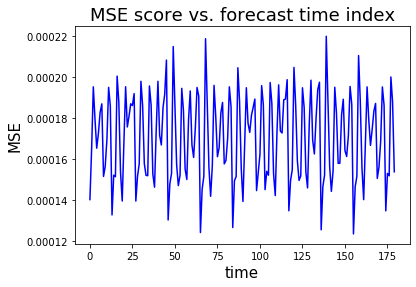

In [71]:
plt.plot(range(num_sec),results_table.iloc[0,:], 'b') # green
plt.title("MSE score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("MSE",fontsize=15);
plt.show()

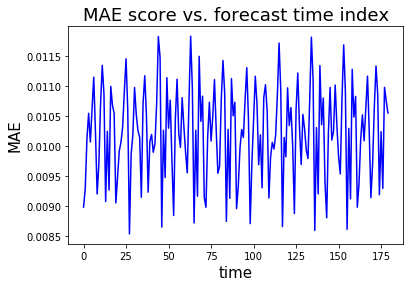

In [72]:
plt.plot(range(num_sec),results_table.iloc[1,:], 'b') # green
plt.title("MAE score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("MAE",fontsize=15);
plt.show()

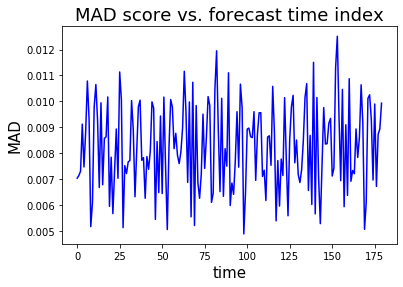

In [73]:
plt.plot(range(num_sec),results_table.iloc[2,:], 'b') # green
plt.title("MAD score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("MAD",fontsize=15);
plt.show()

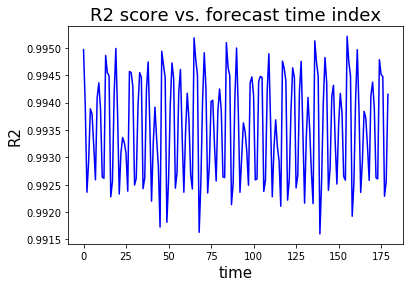

In [74]:
plt.plot(range(num_sec),results_table.iloc[3,:], 'b') # green
plt.title("R2 score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("R2",fontsize=15);
plt.show()

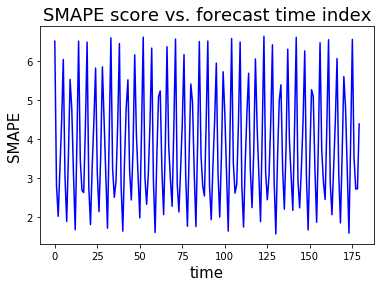

In [75]:
plt.plot(range(num_sec),results_table.iloc[4,:], 'b') # green
plt.title("SMAPE score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("SMAPE",fontsize=15);
plt.show()

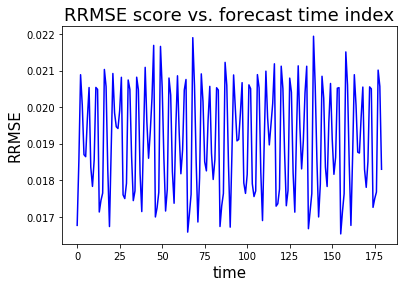

In [76]:
plt.plot(range(num_sec),results_table.iloc[5,:], 'b') # green
plt.title("RRMSE score vs. forecast time index",fontsize=18)
plt.xlabel("time", fontsize=15)
plt.ylabel("RRMSE",fontsize=15);
plt.show()

## 5.4 Output values

In [77]:
Ytest_hat_fl = model.predict(test_generator, verbose=1) 

# Create the multidimensional arrays for the results and ground-truth values
mat_pred = np.zeros((Ytest_fl[0].shape[0],p,Ytest_fl[0].shape[1]))
mat_ground_truth = np.zeros((Ytest_fl[0].shape[0],p,Ytest_fl[0].shape[1]))
mat_time_slice_index = np.zeros((Ytest_fl[0].shape[0],p),dtype=int)
print(mat_pred.shape)
print(mat_ground_truth.shape)
print(mat_time_slice_index.shape)

# Fill the output arrays
for i in range(p):
    for j in range(Ytest_fl[0].shape[0]):
        mat_pred[j,i,:]=Ytest_hat_fl[i][j,:]
        
for i in range(p):
    for j in range(Ytest_fl[0].shape[0]):
        mat_ground_truth[j,i,:]=tensor.T[test_idxs[j]+k+i,:]

for i in range(p):
    for j in range(Ytest_fl[0].shape[0]):
        mat_time_slice_index[j,i]=test_idxs[j]+k+i     
  
# Predicitions not scaled
mat_pred = mat_pred * range_val + min_val


36/36 [==============================] - 0s 1ms/step
(180, 6, 20)
(180, 6, 20)
(180, 6)


In [79]:
pd.DataFrame(mat_ground_truth[:,:,0])

,0,1,2,3,4,5
0,-471.496986,-472.534036,-471.848552,-472.749320,-471.892269,-471.788204
1,-472.534036,-471.848552,-472.749320,-471.892269,-471.788204,-472.447265
2,-471.848552,-472.749320,-471.892269,-471.788204,-472.447265,-471.924983
3,-472.749320,-471.892269,-471.788204,-472.447265,-471.924983,-472.846218
4,-471.892269,-471.788204,-472.447265,-471.924983,-472.846218,-471.519833
...,...,...,...,...,...,...
175,-471.358914,-472.402244,-471.879936,-472.478993,-472.197641,-471.500800
176,-472.402244,-471.879936,-472.478993,-472.197641,-471.500800,-472.481238
177,-471.879936,-472.478993,-472.197641,-471.500800,-472.481238,-471.795742
178,-472.478993,-472.197641,-471.500800,-472.481238,-471.795742,-472.746209


In [80]:
pd.DataFrame(mat_pred[:,:,0])

,0,1,2,3,4,5
0,-474.531648,-473.177551,-472.972051,-473.892885,-472.591754,-472.067988
1,-473.407607,-473.156238,-473.916996,-474.033920,-472.965116,-473.681403
2,-472.249093,-473.908154,-473.279023,-471.757144,-473.395846,-473.117203
3,-473.672501,-471.352675,-474.130910,-470.815809,-472.923607,-473.677753
4,-473.740636,-472.404566,-473.466373,-472.094755,-474.335740,-471.921113
...,...,...,...,...,...,...
175,-474.442079,-473.086725,-472.776894,-473.684952,-473.367841,-471.934010
176,-473.655062,-472.751181,-473.934678,-473.969192,-472.818708,-473.635291
177,-472.693469,-474.091388,-473.337282,-472.686149,-473.384084,-473.186656
178,-473.200404,-471.758806,-474.089036,-470.789062,-473.004132,-473.894324


### Codigo a meter por Rodrigo